# Предсказание связей

Link Prediction (предсказание связей) - это задача из области
графовых методов, направленная на предсказание отношений
(рёбер) между сущностями в графовой структуре. В контексте баз
знаний, где информация представлена в виде графа, задача link
prediction становится важным инструментом для дополнения или
обновления существующей сети отношений.


Задача link prediction заключается в предсказании отсутствующих
рёбер между сущностями, основываясь на известных связях в графе.

Практическое применение link prediction:
* Предсказание новых связей между пользователями или
группами.
* Предсказание взаимодействий между белками в
биологических сетях.
* Предсказание связей между пользователями и товарами.
* Пополнение базы знаний новыми фактами.

В контексте машинного обучения и графовых моделей, задача
link prediction решается с использованием методов, таких как
графовые эмбеддинги, глубокие нейронные сети, и другие
алгоритмы, специфичные для графовых данных.

In [1]:
!pip install pykeen matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


In [15]:
import torch
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen.evaluation import ClassificationEvaluator
from pykeen.datasets import CoDExSmall
from pykeen.predict import predict_target

In [16]:
# Load the CoDExSmall dataset
dataset = CoDExSmall()

In [17]:
# Metrics storage

roc_auc_score = {"ComplEx": [], "HolE": []}
precision = {"ComplEx": [], "HolE": []}
accuracy = {"ComplEx": [], "HolE": []}
f1 = {"ComplEx": [], "HolE": []}

# Store results for different pipelines
pipeline_results_list = {"ComplEx": [], "HolE": []}

In [18]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Use ClassificationEvaluator for metrics calculation
evaluator = ClassificationEvaluator()

# Train the ComplEx model for different epochs and calculate metrics
epochs = [1, 20, 50, 100, 250]
for model_name in ["ComplEx", "HolE"]:
    for epoch in epochs:
        pipeline_results = pipeline(
            model=model_name,
            dataset=dataset,
            training_kwargs=dict(num_epochs=epoch),
            device=device
        )
        pipeline_results_list[model_name].append(pipeline_results)

        model = pipeline_results.model
        metrics = evaluator.evaluate(
            model,
            dataset.testing.mapped_triples,
            additional_filter_triples=[
                dataset.training.mapped_triples,
                dataset.validation.mapped_triples
            ]
        )

        roc_auc_score[model_name].append(metrics.get_metric('roc_auc_score'))
        precision[model_name].append(metrics.get_metric('average_precision_score'))
        accuracy[model_name].append(metrics.get_metric('accuracy_score'))
        f1[model_name].append(metrics.get_metric('f1_score'))

## Визуализация метрик

In [20]:
def plot_metrics(roc_auc_score, precision, accuracy, f1, name, epochs):
    # В качесте лейблов используем список значений эпох
    labels = epochs

    # Plotting ROC AUC scores
    plt.plot(labels, roc_auc_score[name], label='ROC_AUC')

    # Plotting precision scores
    plt.plot(labels, precision[name], label='Precision')

    # Plotting accuracy scores
    plt.plot(labels, accuracy[name], label='Accuracy')

    # Plotting F1
    plt.plot(labels, f1[name], label='F1')

    # Добавляем легенду, лейблы и название
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Model Evaluation Metrics for ' + name)

    # Отрисовываем график
    plt.show()

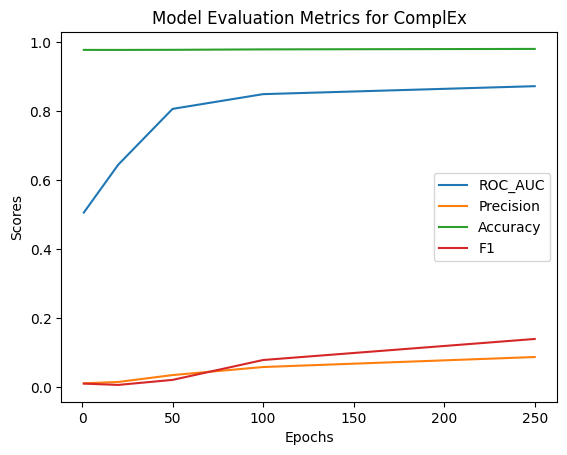

In [21]:
plot_metrics(roc_auc_score, precision, accuracy, f1, "ComplEx", epochs)

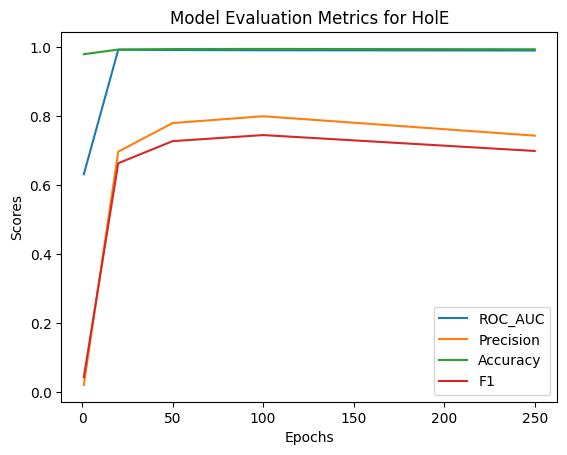

In [22]:
plot_metrics(roc_auc_score, precision, accuracy, f1, "HolE", epochs)

## Link prediction

In [23]:
def print_prediction_results(pipeline_results_list, dataset, name):
    print(f'Модель {name}')
    print('---------------------')
    for idx, ep in enumerate(epochs):
        pipeline_result = pipeline_results_list[name][idx]

        # Получаем доступное отношение и сущность
        available_relation = next(iter(dataset.relation_to_id))
        available_entity = next(iter(dataset.entity_to_id))

        # Используем predict_target с доступным отношением и сущностью
        pred = predict_target(
            model=pipeline_result.model,
            relation=available_relation,
            head=available_entity,
            triples_factory=pipeline_result.training,
        )

        pred_filtered = pred.filter_triples(dataset.training)
        pred_annotated = pred_filtered.add_membership_columns(validation=dataset.validation, testing=dataset.testing)
        pred_df = pred_annotated.df[['tail_label', 'score']]
        print(f'Результат при вычислении {ep} эпох для сущности "{available_entity}" и отношения "{available_relation}"')
        print(pred_df)
        print('__________________________')

In [24]:
print_prediction_results(pipeline_results_list, dataset, "ComplEx")

Модель ComplEx
---------------------
Результат при вычислении 1 эпох для сущности "Q100" и отношения "P101"
     tail_label      score
1029     Q29999  90.957657
0          Q100  90.715485
1944       Q892  77.095901
1510     Q50764  75.991158
442     Q173061  75.948784
...         ...        ...
621     Q198962 -72.578537
1099        Q32 -74.336235
923     Q261812 -75.455811
1170     Q34787 -78.477631
729     Q217191 -80.607742

[2034 rows x 2 columns]
__________________________
Результат при вычислении 20 эпох для сущности "Q100" и отношения "P101"
     tail_label      score
565     Q190251  86.198204
886     Q242418  84.275833
790     Q230068  83.109673
1496     Q49734  82.039536
1542     Q54860  78.609352
...         ...        ...
752     Q221364 -79.430359
167     Q126399 -80.605377
909      Q25320 -84.310822
1154     Q34433 -89.924164
1705    Q704931 -92.627266

[2034 rows x 2 columns]
__________________________
Результат при вычислении 50 эпох для сущности "Q100" и отношения "P1

In [25]:
print_prediction_results(pipeline_results_list, dataset, "HolE")

Модель HolE
---------------------
Результат при вычислении 1 эпох для сущности "Q100" и отношения "P101"
     tail_label     score
470     Q180468  0.366779
418     Q168992  0.355372
1093    Q318004  0.317357
1305     Q41042  0.310453
1711    Q708963  0.302363
...         ...       ...
1563       Q563 -0.295985
761     Q224650 -0.335334
1053    Q310755 -0.335856
1215     Q36233 -0.341906
1333     Q42398 -0.342358

[2034 rows x 2 columns]
__________________________
Результат при вычислении 20 эпох для сущности "Q100" и отношения "P101"
     tail_label     score
1744      Q7314  1.794383
329     Q155860  1.747312
1290      Q4029  1.682600
691     Q213512  1.658115
1479     Q48990  1.610746
...         ...       ...
1949       Q902 -1.358379
364         Q16 -1.379659
2024       Q977 -1.444387
353        Q159 -1.481950
1673       Q668 -1.643478

[2034 rows x 2 columns]
__________________________
Результат при вычислении 50 эпох для сущности "Q100" и отношения "P101"
     tail_label     sco